In [36]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('../src')))
from constant_drift_diffusion import *
from accumulators import *

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical

In [37]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [38]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [39]:
# simulation 
N_SIM = 500
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 50
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 200

## Simulator Test

In [43]:
n_obs = 100
a     = 3.0
ndt   = 0.2
bias  = 0.5
kappa = 5
theta = np.array([a, ndt, bias, kappa])

unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
condition = to_categorical(pd.factorize(amplitude)[0])

rt, resp = const_dm_simulator(theta, 1, amplitude)

In [44]:
p_, x_ = const_dm_batch_simulator(32, 100)
x_.shape

(32, 100, 12)

## BayesFlow

In [45]:
class CustomSummary(tf.keras.Model):
    
    def __init__(self, meta_inv, n_out=10):
        super(CustomSummary, self).__init__()
        self.inv = InvariantNetwork(meta_inv)
        self.out = Dense(n_out)
        
    def call(self, x):
        return self.out(self.inv(x)) 

In [46]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

# invertable inference network
inf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(inf_meta)
summary_net = CustomSummary(sum_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

In [47]:
# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=const_dm_batch_simulator,
    learning_rate=learning_rate,
    checkpoint_path='../src/selected_checkpoints/const_dm2',
    clip_value=3,
    max_to_keep=5
)

Initializing networks from scratch.


In [56]:
# Learning-rate decay
trainer.optimizer = tf.keras.optimizers.Adam(0.00007)

In [ ]:
# %%time
losses = trainer.train_online(35, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

## Paramter Recovery

In [49]:
# Simulate and amortized inference
p_, x_ = const_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)

In [54]:
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

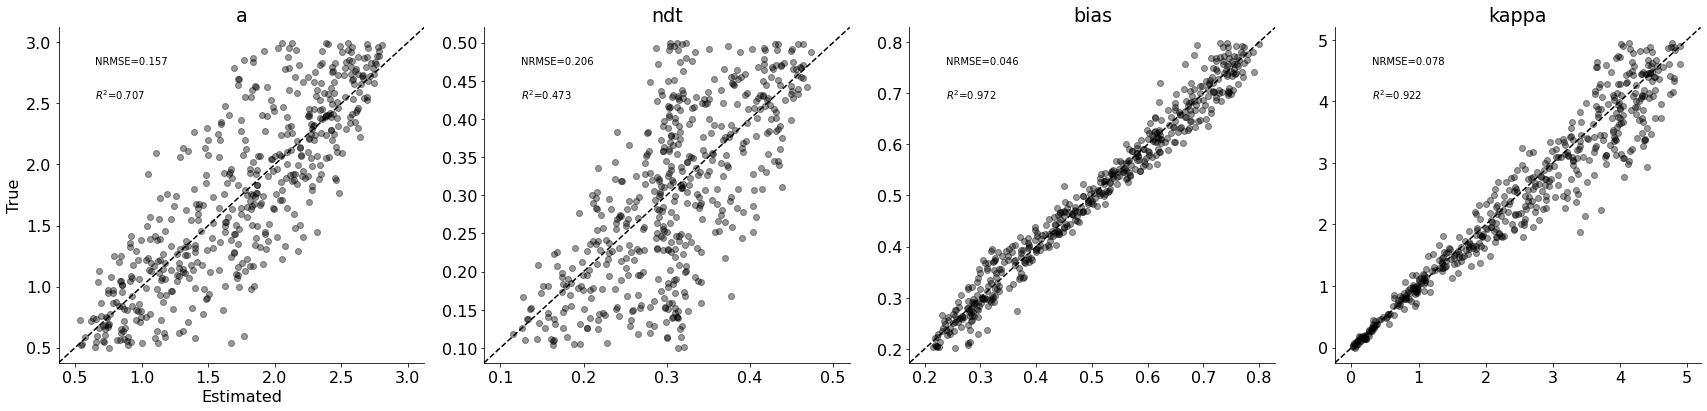

In [55]:
# Recovery plot
f = true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(24,6),font_size=16)

In [25]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = const_dm_batch_simulator(n_sbc, N_OBS)

In [26]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

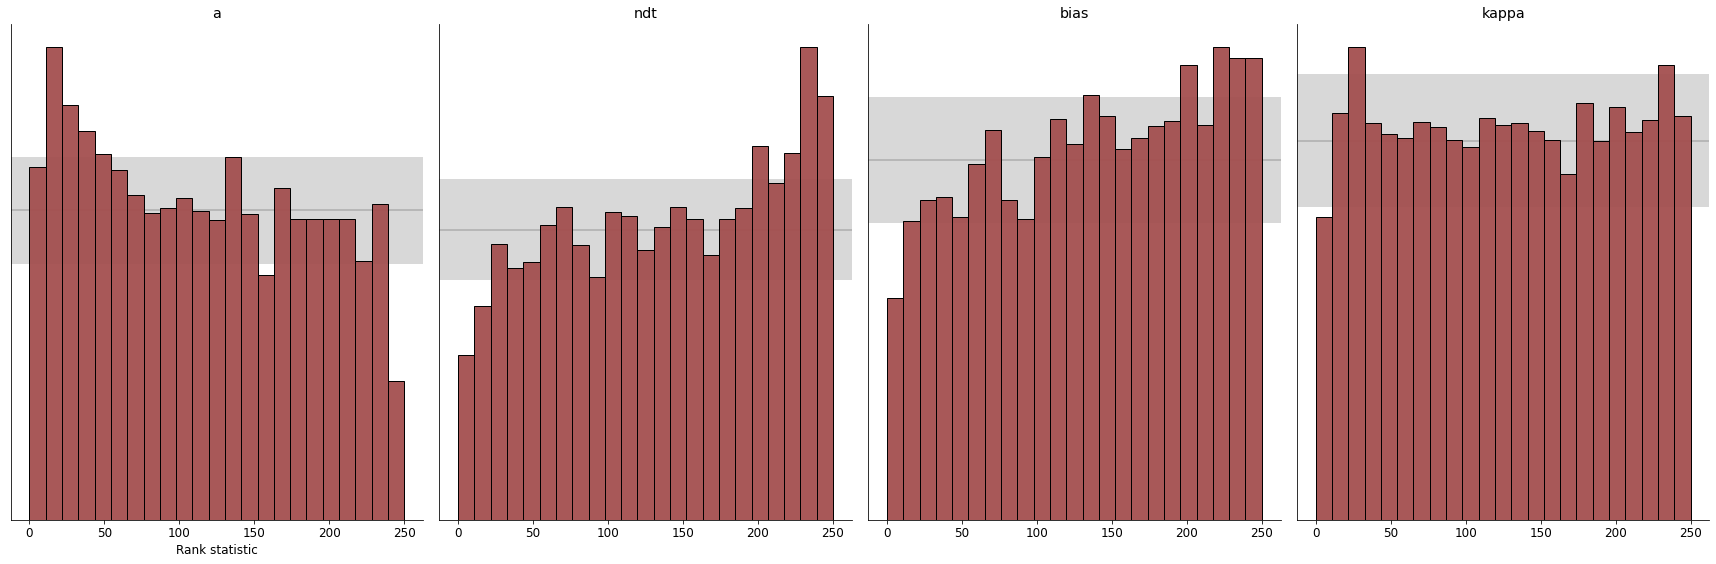

In [27]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(24, 8), bins=23)